## Imports

In [2]:
from numpy import array, arange, zeros, transpose
from matplotlib import pyplot, rc
from math import pi

## The System Models
The following two differential equations were derived in lecture. They represent the dynamics associated with a DC Motor with viscous damping and inertia. The equations here should be modified to reflect the dynamics associated with each axis of your term project design.

$$
\begin{array}{rl}
\frac{di_m}{dt}      &= \frac{1}{L} \left( V_m - R i_m - K_v \Omega_m \right) \\
\frac{d\Omega_m}{dt} &= \frac{1}{J} \left( K_t i_m - b \Omega_m \right) \\
\frac{d\theta_m}{dt} &= \Omega_m
\end{array}
$$

The preceding equations can be combined into a single vector equation so that we can solve it using vector based ODE solution techniques.

$$
\begin{array}{rl}
\frac{d}{dt}
    \begin{bmatrix}
        i_m \\
        \Omega_m \\
        \theta_m
    \end{bmatrix}
&=
\begin{bmatrix}
    \frac{1}{L} \left( V_m - R i_m - K_v \Omega_m \right) \\
    \frac{1}{J} \left( K_t i_m - b \Omega_m \right) \\
    \Omega_m
\end{bmatrix} \\
\frac{d}{dt}
    \begin{bmatrix}
        i_m \\
        \Omega_m \\
        \theta_m
    \end{bmatrix}
&=
\begin{bmatrix}
    -\frac{R}{L} & -\frac{K_t}{L} & 0 \\
    \frac{K_t}{J} & -\frac{b}{J} & 0 \\
    0 & 1 & 0
\end{bmatrix}
    \begin{bmatrix}
        i_m \\
        \Omega_m \\
        \theta_m
    \end{bmatrix}
+
\begin{bmatrix}
    \frac{1}{L} \\
    0 \\
    0 
\end{bmatrix}
    \begin{bmatrix}
        V_m
    \end{bmatrix}
\end{array}
$$

The preceding sytem of equations are of the form $\mathbf{\dot{x}} = A \mathbf{x} + B \mathbf{u}$ where $A$ is the state-to-state coupling matrix, $B$ is the input-to-state coupling matrix, $\mathbf{x}$ is the state vector, and $\mathbf{u}$ is the input vector.

The matrix representation with $A$ and $B$ is actually a special case for linear time-invariant systems; the general expression for nonlinear time-varying systems is $\mathbf{\dot{x}} = \mathbf{f}\left(t, \mathbf{x}\right)$. This system of equations represent the dynamics of the system; that is, the all of the differential equations of motion are wrapped up in one large matrix equation.

It is most often the case that outputs of interest are not present in the state vector directly. In such instances a second set of equations is utilized to select outputs of interest in the form $\mathbf{y} = \mathbf{g}\left(t, \mathbf{x}\right)$. These can also be simplified for linear time-invariant systems using matrices. For LTI systems, the output equations reduce to $\mathbf{y} = C\mathbf{x}+D\mathbf{u}$. The $C$ matrix is referred to as the state-to-output coupling matrix and the $D$ matrix is referred to as the input-to-output coupling matrix. It is common to define $C$ as an identity matrix and $D$ as the zero matrix, resulting in output equations $\mathbf{y}=\mathbf{x}$ if all the desired outputs are state variables.

For the DC motor model, the desired outputs will include all state variables and also the input voltage.
$$
\begin{array}{rl}
\begin{bmatrix}
    i_m \\
    \Omega_m \\
    \theta_m \\
    V_m
\end{bmatrix}
&=
\begin{bmatrix}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & 1 \\
    0 & 0 & 0 
\end{bmatrix}
    \begin{bmatrix}
        i_m \\
        \Omega_m \\
        \theta_m
    \end{bmatrix}
+
\begin{bmatrix}
    0 \\
    0 \\
    0 \\
    1 
\end{bmatrix}
    \begin{bmatrix}
        V_m
    \end{bmatrix}
\end{array}
$$

In the code below, there are two different functions defined; each one implements both the state equations, $\mathbf{\dot{x}} = A \mathbf{x} + B \mathbf{u}$, and the output equations, $\mathbf{y} = C\mathbf{x}+D\mathbf{u}$. The difference between the two functions is that the first implements an open-loop simulation and the second implements a closed loop simulation. That is, the first function uses a constant supply voltage of $V_m = 12\text{V}$ and the second function uses a simple proportional-derivative feedback law that defines $V_m = k_p \left( \theta_{desired} - \theta_m \right) + k_d \left( \Omega_{desired} - \Omega_m \right)$ where $k_p$ is the proportional gain in units of $\frac{\text{V}}{\text{rad}}$, $k_d$ is the derivative gain in units of $\frac{\text{V} \cdot \text{s}}{\text{rad}}$, $\theta_{desired}$ is the desired angle of the motor shaft in $\text{rad}$, and $\Omega_{desired}$ is the desired velocity of the motor shaft in $\frac{\text{rad}}{\text{s}}$, set to zero for a step response.

In [3]:
# Electromechanical properties Motor 1
J      = 6.8e-7     # Mass moment of inertia   [kg*m^2]
b      = 0          # Viscous damping          [N*m*s/rad]
Kt     = 0.0263     # Torque Constant          [N*m/A]
Kv     = Kt         # Back-emf Constant        [V*s/rad]
R      = 9.00       # Terminal Resistance      [ohm]
L      = 4.72e-3    # Terminal Inductance      [H]
Jt2    = 0.05     # Mass moment of inertia for motor 1   [kg*m^2]
bt2    = 0.00001    # friction damping from baring                
N2     = 4          # Gear ratio 
r     = 0.0254      # radius                    [m]
g     = 9.82      # gravity constant          []
m     = 1.014       # mass                      [kg]


# Parameters for closed-loop model
th_des = 2*pi;      # Desired motor angle      [rad]
om_des = 0;         # Desired motor speed      [rad/s]
k_p    = 5;         # Proportional gain        [V/rad]
k_d    = 0.05;      # Derivative gain          [V*s/rad]

# State-to-state coupling matrix
A = array([ [-R/L,  -Kt/L, 0 ],
            [ Kt/J, 1/J*( -(Jt2/N2**2) - (bt2/N2**2)),  m*g*r ],
            [ 0,     1,    0 ] ])

# Input-to-state coupling matrix
B = array([ [1/L],
            [ 0 ],
            [ 0 ] ])

# State-to-output coupling matrix
C = array([ [1, 0, 0],
            [0, 1, 0],
            [0, 0, 1],
            [0, 0, 0] ])

# Input-to-output coupling matrix
D = array([ [0],
            [0],
            [0],
            [1] ])

In [4]:
def system_eqn_OL(t, x):
    '''!@brief      Implements both state equations and output equations for the open loop system
        @param t    The value of time for a given simulation step
        @param x    The value of the state vector for a given simulation step
        @return     A tuple containing both the derivative of the state vector and the output
                    vector for a given simulation step
    '''
    
    # Constant input voltage for open-loop
    # The voltage must be packed in a 1x1 matrix for the arithmetic below
    u = array([ [12] ]);
    
    # State equations
    xd =  A@x+B@u;
    
    # Output Equations
    y  =  C@x+D@u;
    
    return xd, y

In [5]:
def system_eqn_CL(t, x):
    '''!@brief      Implements both state equations and output equations for the open loop system
        @param t    The value of time for a given simulation step
        @param x    The value of the state vector for a given simulation step
        @return     A tuple containing both the derivative of the state vector and the output
                    vector for a given simulation step
    '''
    
    # Applied motor voltage is proportional to error in motor angle
    V_m = k_p*(th_des - x[2,0]) + k_d*(om_des - x[1,0])
    
    # For a more realistic simulation, the motor voltage will be saturated at 12V
    V_m = min(max(V_m,-12),12)
    
    # The input must be packed into a 1x1 matrix for the arithmetic below
    u = array([ [V_m] ]);
    
    # State equations
    xd =  A@x+B@u;
    
    # Output Equations
    y  =  C@x+D@u;
    
    return xd, y

## Forward Euler Solver
For this example, as provided a simple solver will be implemented for you. That is, a first-order forward Euler solver is implemented below. It can be used as a template or example that you may extend to use a higher-order integration method, such as the Runge-Kutta method, see below for additional details.

The details of the solver will not be covered here in great depth, however it is important to understand the integration method in some depth to complete the assignment. The fundamental assumption used in a first-order solver is that over a small window of time the state of the system changes at a constant rate. That is, the derivative of the state vector, $\dot{\mathbf{x}}$, is assumed constant over a short window of time, $\Delta t$. This assumption leads directly to an integration algorithm called Euler's method. There are multiple formulations of Euler's method, and the simplest form is the Forward Euler method. The method predicts future states of the system based on knowledge of the present state and its derivative at a given instant in time. It is called a forward Euler method because it uses information at a given step $n$ to predict the future state at step $n+1$.

$$
\begin{array}{rl}
\frac{\Delta \mathbf{x}}{\Delta t} &= \mathbf{\dot{x}}_n \\
\Delta \mathbf{x} &= \mathbf{\dot{x}}_n \Delta t \\
\mathbf{x}_{n+1} - \mathbf{x}_{n} &= \mathbf{\dot{x}}_n \Delta t \\
\mathbf{x}_{n+1} &= \mathbf{x}_{n} + \mathbf{\dot{x}}_n \Delta t
\end{array}
$$
where, 
$$
\begin{array}{rl}
\mathbf{\dot{x}}_n &= \mathbf{f}(t,\mathbf{x}_n).
\end{array}
$$

In [6]:
def Euler_solver(fcn, x_0, tspan, tstep):
    '''!@brief        Implements a first-order forward euler solver
        @param fcn    A function handle to the function to solve
        @param x_0    The initial value of the state vector
        @param tspan  A span of time over which to solve the system specified as a list
                      with two elements representing initial and final time values
        @param tstep  The step size to use for the integration algorithm
        @return       A tuple containing both an array of time values and an array
                      of output values
    '''
    
    # Define a column of time values
    tout = arange(tspan[0], tspan[1]+tstep, tstep)

    # Preallocate an array of zeros to store state values
    xout = zeros([len(tout)+1,len(x_0)])
    
    # Determine the dimension of the output vector
    r = len(fcn(0,x_0)[1])
    
    # Preallocate an array of zeros to store output values
    yout = zeros([len(tout),r])

    # Initialize output array with intial state vector
    xout[0][:] = x_0.transpose()

    # Iterate through the algorithm but stop one cycle early because
    # the algorithm predicts one cycle into the future
    for n in range(len(tout)):
        
        # Pull out a row from the solution array and transpose to get
        # the state vector as a column
        x = xout[[n]].transpose()
        
        # Pull out the present value of time
        t = tout[n]
        
        # Evaluate the function handle at the present time with the
        # present value of the state vector to compute the derivative
        xd, y = fcn(t, x)
        
        # Apply the update rule for Euler's method. The derivative value
        # must be transposed back to a row here for the dimensions to line up.
        xout[n+1] = xout[n] + xd.transpose()*tstep
        yout[n] = y.transpose()
    
    return tout, yout

## Runge-Kutta Method (4th-order)
The following algorithm is presented without derivation, but is a marked improvement over Euler's method presented above. The integration technique is fourth-order, instead first-order, so has a much smaller truncation error for a given step size. Using an "RK" solver will allow you to use a much more reasonable step size and still get a solution of reasonable accuracy. The algorithm is similar to Euler's method, however it splits the window of time, $\Delta t$, in half and computes the derivative several times at the start of the time window, in the middle, and at the end. These derivatives are used to find a weighted average which is then used in a standard Euler step.
$$
\begin{array}{rl}
\mathbf{x}_{n+1} &= \mathbf{x}_{n} + \frac{1}{6} \left(\mathbf{k}_1 + 2 \mathbf{k}_2 + 2 \mathbf{k}_3 + \mathbf{k}_4 \right) \Delta t
\end{array}
$$
where,
$$
\begin{array}{rll}
\mathbf{k}_1 &= \mathbf{f}(t, & \mathbf{x}_n) \\
\mathbf{k}_2 &= \mathbf{f}(t+\frac{1}{2}\Delta t, & \mathbf{x}_n+\frac{1}{2} k_1 \Delta t) \\
\mathbf{k}_3 &= \mathbf{f}(t+\frac{1}{2}\Delta t, & \mathbf{x}_n+\frac{1}{2} k_2 \Delta t) \\
\mathbf{k}_4 &= \mathbf{f}(t+\Delta t, & \mathbf{x}_n+k_3 \Delta t).
\end{array}
$$

In [7]:
def RK4_solver(fcn, x_0, tspan, tstep):
    '''!@brief        Implements a first-order forward euler solver
        @param fcn    A function handle to the function to solve
        @param x_0    The initial value of the state vector
        @param tspan  A span of time over which to solve the system specified as a list
                      with two elements representing initial and final time values
        @param tstep  The step size to use for the integration algorithm
        @return       A tuple containing both an array of time values and an array
                      of output values
    '''
    # Define a column of time values
    t_out = arange(tspan[0], tspan[1]+tstep, tstep)

    # Preallocate an array of zeros to store state values
    x_out = zeros([len(t_out)+1,len(x_0)])
    
    
    # Determine the dimension of the output vector
    r = len(fcn(0,x_0)[1])
    
    # Preallocate an array of zeros to store output values
    y_out = zeros([len(t_out),r])
    
     # Initialize output array with intial state vector
    x_out[0][:] = x_0.transpose()
    
    for i in range(len(t_out)):
        # Pull out a row from the solution array and transpose to get
        # the state vector as a column
        x = x_out[[i]].transpose()
        
        # Pull out the present value of time
        t = t_out[i]
        
        
        k1, y = fcn(t, x)
        k2, y = fcn(t+(0.5*tstep), x+(k1*tstep/2))
        k3, y = fcn(t+(0.5*tstep), x+(k2*tstep/2) )
        k4, y = fcn(t+tstep, x+(k3*tstep))
                 
        x_out[i+1] = x_out[i] + 1/6*(k1 + 2*k2 + 2*k3 + k4).transpose()*tstep
        y_out[i] = y.transpose()
        
    return t_out, y_out

## Running the Open-Loop Simulation

In [8]:
# The following initial conditions will be used by both the open-loop and
# closed-loop simulations
x_0 = array([ [0],
              [0],
              [0] ])
# Solve the open loop system over a 0.1 second time window with 1 ms steps
t_OL, y_OL = Euler_solver(system_eqn_OL, x_0, [0, 0.1], 1e-6)

## Plotting the Open-Loop Simulation Results

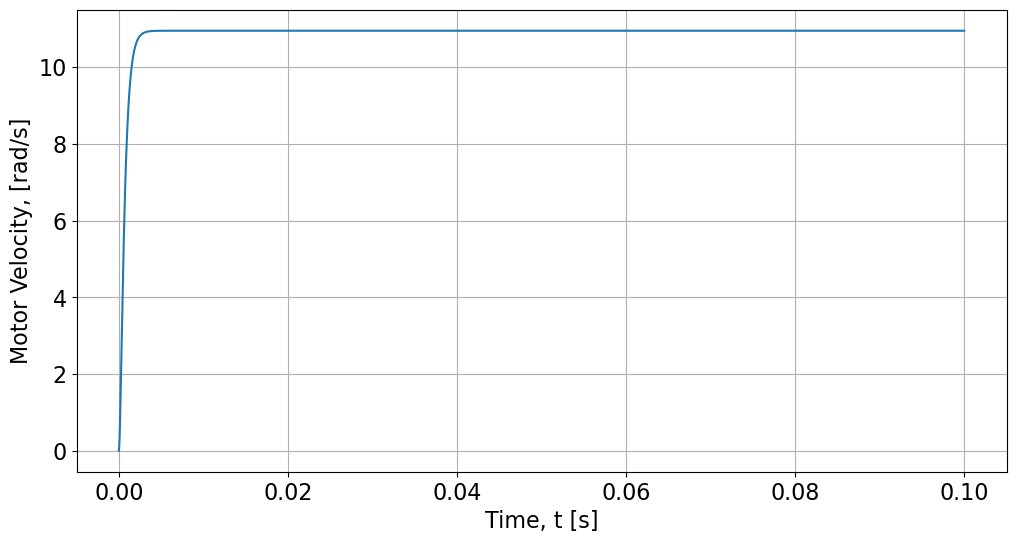

In [9]:
# Enlarge font size
rc('font', **{'size'   : 16})

pyplot.figure(figsize=(12,6))
pyplot.plot(t_OL, y_OL[:,1])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Motor Velocity, [rad/s]')
pyplot.grid()

## Running the Closed-Loop Simulation

In [10]:
# Solve the closed loop system over a 0.1 second time window with 1 ms steps
t_CL, y_CL = Euler_solver(system_eqn_CL, x_0, [0, 1], 1e-6)

## Plotting the Closed-Loop Simulation Results

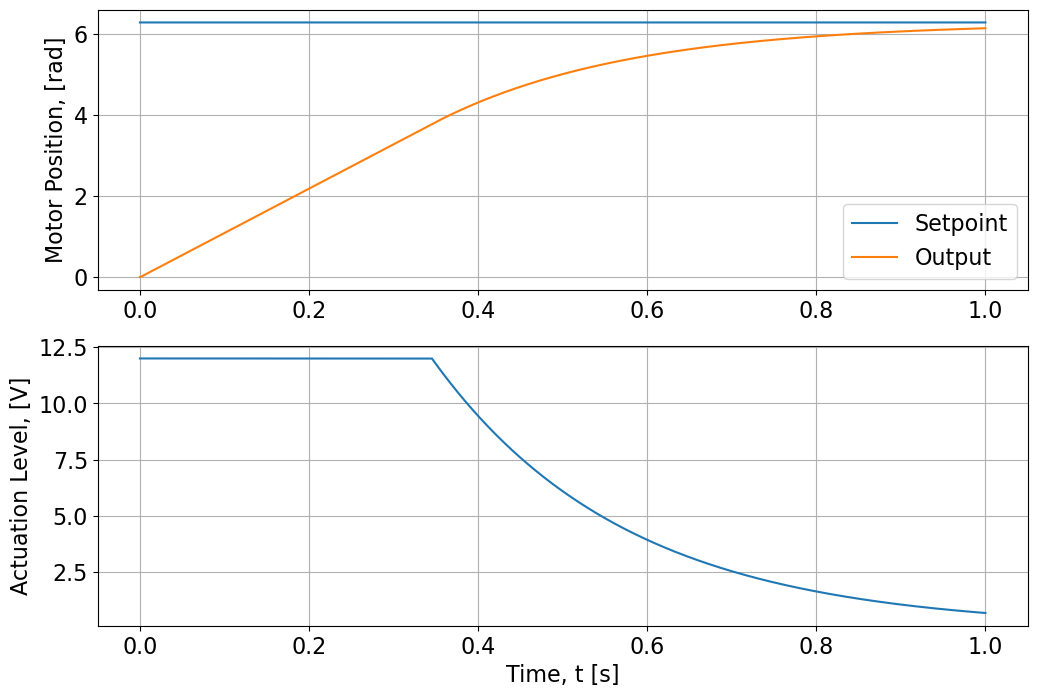

In [11]:
pyplot.figure(figsize=(12,8))

pyplot.subplot(2,1,1)
pyplot.plot(t_CL, len(t_CL)*[th_des], label="Setpoint")
pyplot.plot(t_CL, y_CL[:,2], label="Output")
pyplot.ylabel('Motor Position, [rad]')
pyplot.legend(loc='lower right')
pyplot.grid()

pyplot.subplot(2,1,2)
pyplot.plot(t_CL, y_CL[:,3])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Actuation Level, [V]')
pyplot.grid()

In [94]:
# The following initial conditions will be used by both the open-loop and
# closed-loop simulations
x_0 = array([ [0],
              [0],
              [0] ])
# Solve the open loop system over a 0.1 second time window with 1 ms steps
t_1, y_1 = RK4_solver(system_eqn_OL, x_0, [0, 0.1], 1e-6)



In [95]:
print( len(y_1) ) 


100002


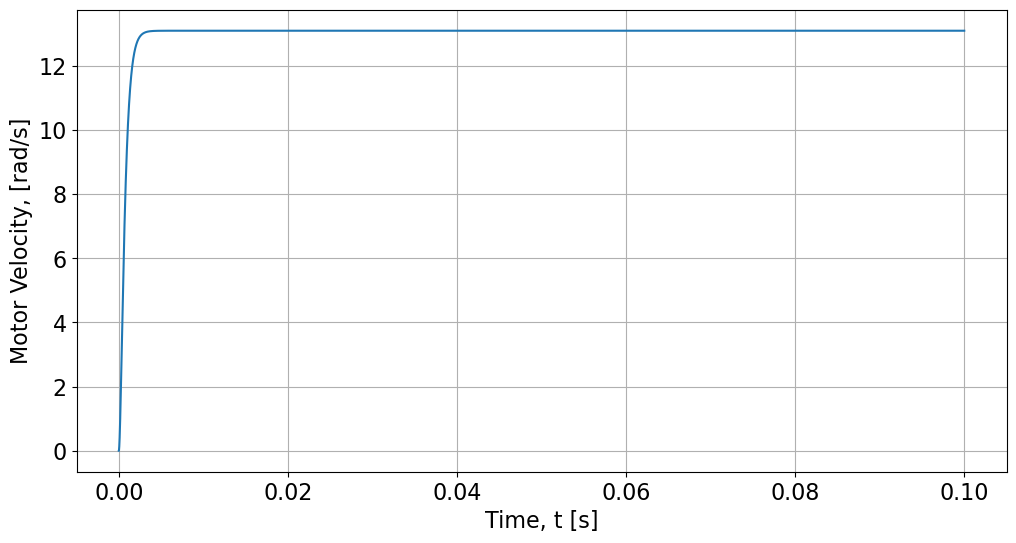

In [96]:
# Enlarge font size
rc('font', **{'size'   : 16})

pyplot.figure(figsize=(12,6))
pyplot.plot(t_1, y_1[:,1])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Motor Velocity, [rad/s]')
pyplot.grid()

In [101]:
# Solve the closed loop system over a 0.1 second time window with 1 ms steps
t_2, y_2 = RK4_solver(system_eqn_CL, x_0, [0, 1], 1e-6)

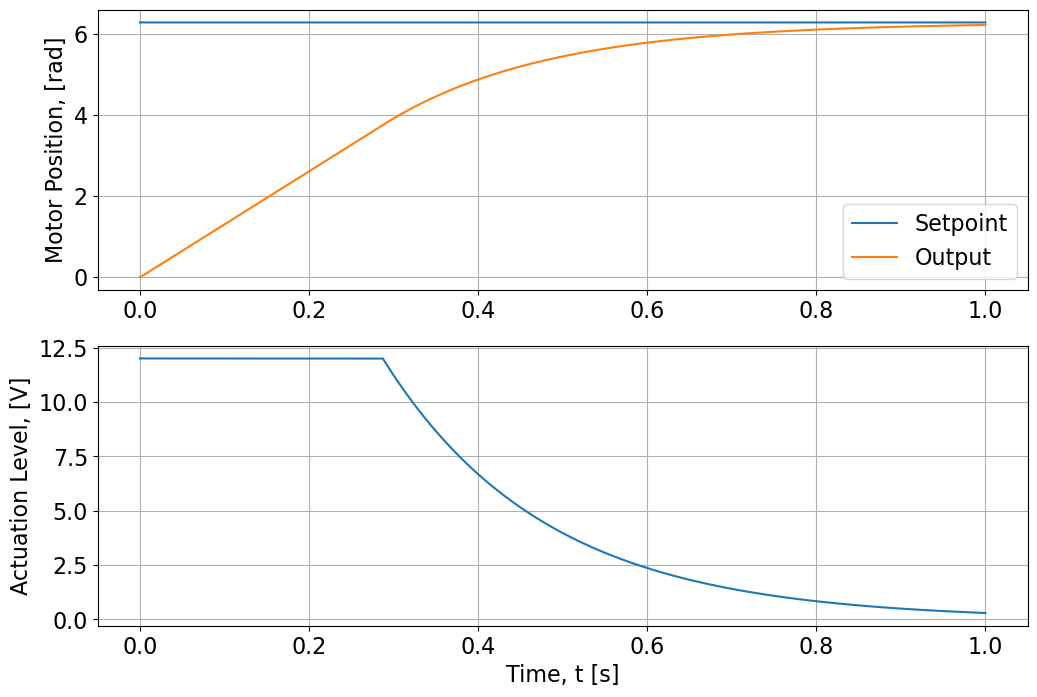

In [102]:
pyplot.figure(figsize=(12,8))

pyplot.subplot(2,1,1)
pyplot.plot(t_2, len(t_2)*[th_des], label="Setpoint")
pyplot.plot(t_2, y_2[:,2], label="Output")
pyplot.ylabel('Motor Position, [rad]')
pyplot.legend(loc='lower right')
pyplot.grid()

pyplot.subplot(2,1,2)
pyplot.plot(t_2, y_2[:,3])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Actuation Level, [V]')
pyplot.grid()